In [1]:
# STEP 1: Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from datetime import timedelta
import os
from datetime import datetime
from IPython.display import FileLink, HTML
from ydata_profiling import ProfileReport
from IPython.display import display, HTML


In [2]:
# STEP 2: Data Load + Sort
df = pd.read_csv(r"C:\Users\Krishna.x.Jaiswal\Downloads\standby_crew_ml\DEL_SBY_prepared_data (UAT).csv")

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

df.head()

,Date,Station,Duty Window,Duty Window Number,Rank,Pairing Start Count,Standby Activation Count
0,2025-07-01,DEL,0-4,1,CP,3,2
1,2025-07-01,DEL,20-24,6,FO,13,5
2,2025-07-01,DEL,20-24,6,CP,30,8
3,2025-07-01,DEL,16-20,5,FO,37,7
4,2025-07-01,DEL,12-16,4,FO,27,7


In [3]:
# STEP A: Install ydata-profiling (modern pandas-profiling)
%pip install -q ydata-profiling

Note: you may need to restart the kernel to use updated packages.


In [4]:
# STEP B: Generate a professional data profile HTML report


timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
report_title = f"Standby Crew Data Profile — {timestamp}"

output_dir = "exports"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, f"data_profile_{timestamp}.html")

profile = ProfileReport(
    df,
    title=report_title,
    explorative=True,
    minimal=False,
    progress_bar=True
)

profile.to_file(output_path)
print(f"Profile saved to: {output_path}")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 531.30it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Profile saved to: exports\data_profile_20260107_111938.html


In [5]:
# STEP C: Provide a download/open link to the HTML report
try:
    display(FileLink(output_path))
    display(HTML(f"<p style='font-family:Segoe UI; font-size:14px'>"
                 f"Report Title: <b>{report_title}</b><br>"
                 f"Saved at: <code>{output_path}</code></p>"))
except Exception as e:
    print("Unable to render link:", e)

c:\Users\Krishna.x.Jaiswal\Downloads\standby_crew_ml\exports\data_profile_20260107_111938.html

In [6]:
df.head()

,Date,Station,Duty Window,Duty Window Number,Rank,Pairing Start Count,Standby Activation Count
0,2025-07-01,DEL,0-4,1,CP,3,2
1,2025-07-01,DEL,20-24,6,FO,13,5
2,2025-07-01,DEL,20-24,6,CP,30,8
3,2025-07-01,DEL,16-20,5,FO,37,7
4,2025-07-01,DEL,12-16,4,FO,27,7


In [7]:
df.shape

(1104, 7)

In [8]:
# STEP 3: Encoding
# Rank encoding
df['Rank'] = df['Rank'].map({'FO': 0, 'CP': 1})

# Station encoding (optional feature; used for grouping and can be added as a model feature if desired)
le_station = LabelEncoder()
df['Station_enc'] = le_station.fit_transform(df['Station'])

In [9]:
# STEP 4: Time Features
df['dayofweek'] = df['Date'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)
df['week'] = df['Date'].dt.isocalendar().week.astype(int)
df['month'] = df['Date'].dt.month

df.head()

,Date,Station,Duty Window,Duty Window Number,Rank,Pairing Start Count,Standby Activation Count,Station_enc,dayofweek,is_weekend,week,month
0,2025-07-01,DEL,0-4,1,1,3,2,0,1,0,27,7
1,2025-07-01,DEL,20-24,6,0,13,5,0,1,0,27,7
2,2025-07-01,DEL,20-24,6,1,30,8,0,1,0,27,7
3,2025-07-01,DEL,16-20,5,0,37,7,0,1,0,27,7
4,2025-07-01,DEL,12-16,4,0,27,7,0,1,0,27,7


In [10]:
# STEP 5: Lag & Rolling Features using Standby Activation Count
TARGET_COL = 'Standby Activation Count'
group_cols = ['Station', 'Duty Window Number', 'Rank']

# Lags of the target
df['lag_1'] = df.groupby(group_cols)[TARGET_COL].shift(1)
df['lag_7'] = df.groupby(group_cols)[TARGET_COL].shift(7)
df['lag_14'] = df.groupby(group_cols)[TARGET_COL].shift(14)

# Rolling mean of last 7 days (using previous day as end of window)
df['rolling_7'] = (
    df.groupby(group_cols)[TARGET_COL]
    .shift(1)
    .rolling(7)
    .mean()
)

df.head()

,Date,Station,Duty Window,Duty Window Number,Rank,Pairing Start Count,Standby Activation Count,Station_enc,dayofweek,is_weekend,week,month,lag_1,lag_7,lag_14,rolling_7
0,2025-07-01,DEL,0-4,1,1,3,2,0,1,0,27,7,NaN,NaN,NaN,NaN
1,2025-07-01,DEL,20-24,6,0,13,5,0,1,0,27,7,NaN,NaN,NaN,NaN
2,2025-07-01,DEL,20-24,6,1,30,8,0,1,0,27,7,NaN,NaN,NaN,NaN
3,2025-07-01,DEL,16-20,5,0,37,7,0,1,0,27,7,NaN,NaN,NaN,NaN
4,2025-07-01,DEL,12-16,4,0,27,7,0,1,0,27,7,NaN,NaN,NaN,NaN


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1104 entries, 0 to 1103
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      1104 non-null   datetime64[ns]
 1   Station                   1104 non-null   object        
 2   Duty Window               1104 non-null   object        
 3   Duty Window Number        1104 non-null   int64         
 4   Rank                      1104 non-null   int64         
 5   Pairing Start Count       1104 non-null   int64         
 6   Standby Activation Count  1104 non-null   int64         
 7   Station_enc               1104 non-null   int64         
 8   dayofweek                 1104 non-null   int32         
 9   is_weekend                1104 non-null   int64         
 10  week                      1104 non-null   int64         
 11  month                     1104 non-null   int32         
 12  lag_1               

In [12]:
# find the percentage of missing values in each column
(df.isnull().sum() / len(df) * 100).round(2)


Date                         0.00
Station                      0.00
Duty Window                  0.00
Duty Window Number           0.00
Rank                         0.00
Pairing Start Count          0.00
Standby Activation Count     0.00
Station_enc                  0.00
dayofweek                    0.00
is_weekend                   0.00
week                         0.00
month                        0.00
lag_1                        1.09
lag_7                        7.61
lag_14                      15.22
rolling_7                    1.63
dtype: float64

In [13]:
# STEP 5.1: Safe imputation for early-history NaNs (within-group only)
# Recompute rolling_7 with shorter window tolerance
df['rolling_7'] = (
    df.groupby(group_cols)[TARGET_COL]
      .shift(1)
      .rolling(7, min_periods=1) \
      .mean()
)

# Fallbacks: prefer nearer history
df['lag_7']  = df['lag_7'].fillna(df['lag_1'])
df['lag_14'] = df['lag_14'].fillna(df['lag_7']).fillna(df['lag_1'])
df['rolling_7'] = df['rolling_7'].fillna(df['lag_1'])

# Build modeling frame: drop only rows that still lack lag_1 (first row per group)
df_model = df.dropna(subset=['lag_1']).reset_index(drop=True)


In [14]:
df_model.shape

(1092, 16)

In [15]:
# Replace the null-percentage check to inspect the modeling frame (not raw df)
null_pct = df_model.isnull().mean().mul(100).round(2)
display(null_pct)

print(f"Dropped cold-start rows: {len(df) - len(df_model)}")


Date                        0.0
Station                     0.0
Duty Window                 0.0
Duty Window Number          0.0
Rank                        0.0
Pairing Start Count         0.0
Standby Activation Count    0.0
Station_enc                 0.0
dayofweek                   0.0
is_weekend                  0.0
week                        0.0
month                       0.0
lag_1                       0.0
lag_7                       0.0
lag_14                      0.0
rolling_7                   0.0
dtype: float64

Dropped cold-start rows: 12


In [16]:
# STEP 6: Drop NA rows (to ensure all engineered features exist)
#df_model = df.dropna().reset_index(drop=True)
df_model.head()

,Date,Station,Duty Window,Duty Window Number,Rank,Pairing Start Count,Standby Activation Count,Station_enc,dayofweek,is_weekend,week,month,lag_1,lag_7,lag_14,rolling_7
0,2025-07-02,DEL,12-16,4,0,33,9,0,2,0,27,7,7.0,7.0,7.0,7.000000
1,2025-07-02,DEL,20-24,6,0,18,1,0,2,0,27,7,5.0,5.0,5.0,6.000000
2,2025-07-02,DEL,20-24,6,1,20,4,0,2,0,27,7,8.0,8.0,8.0,6.666667
3,2025-07-02,DEL,16-20,5,0,37,6,0,2,0,27,7,7.0,7.0,7.0,6.750000
4,2025-07-02,DEL,16-20,5,1,35,9,0,2,0,27,7,4.0,4.0,4.0,6.200000


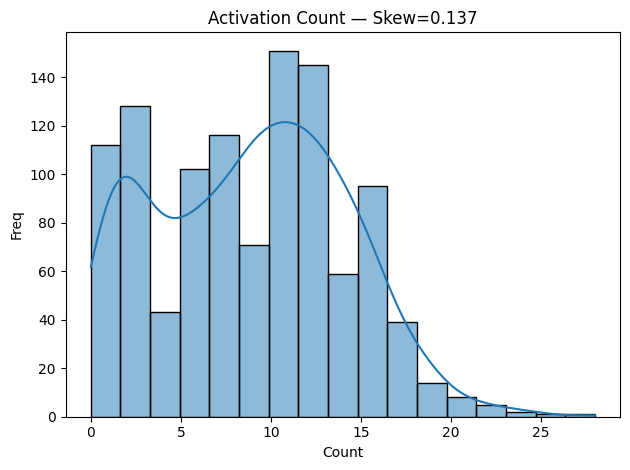

In [17]:
%matplotlib inline
s = (df_model if 'df_model' in globals() else df)['Standby Activation Count'].dropna()
if s.size:
    sns.histplot(s, bins='auto', kde=True); plt.title(f'Activation Count — Skew={float(s.skew()):.3f}'); plt.xlabel('Count'); plt.ylabel('Freq'); plt.tight_layout(); plt.show()
else:
    print('No data to plot')

In [18]:
# STEP 7: Feature / Target Split
features = [
    'Duty Window Number',
    'Rank',
    'dayofweek',
    'is_weekend',
    'week',
    'month',
    'lag_1',
    'lag_7',
    'lag_14',
    'rolling_7'
    # Optionally add 'Station_enc' if you want station effects directly:
    # 'Station_enc'
]

X = df_model[features]
y = df_model[TARGET_COL]

In [19]:
# STEP 8: Chronological Train-Test Split
split_date = '2025-08-31'

train_idx = df_model['Date'] <= split_date
test_idx  = df_model['Date'] >  split_date

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

len(X_train), len(X_test)

# STEP 9: Model Training (LightGBM baseline)
model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)

model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 159
[LightGBM] [Info] Number of data points in the train set: 732, number of used features: 10
[LightGBM] [Info] Start training from score 8.924863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [20]:
X_train.shape, X_test.shape

((732, 10), (360, 10))

In [21]:
# STEP 10: Evaluation (baseline)
pred = model.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))

print("MAE (Standby Activation):", mae)
print("RMSE (Standby Activation):", rmse)

MAE (Standby Activation): 2.79781488898174
RMSE (Standby Activation): 3.702596795454648


In [22]:
# STEP 10: Enhanced Evaluation with MAPE and improved metrics
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate MAPE (Mean Absolute Percentage Error)
    Better than MAE as it gives percentage-based error which is easier to interpret
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Handle zero values to avoid division by zero
    non_zero_mask = y_true != 0
    
    if np.sum(non_zero_mask) == 0:
        return 0.0  # All actual values are zero
    
    # Calculate MAPE only for non-zero actual values
    mape = np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
    return mape

def weighted_absolute_percentage_error(y_true, y_pred):
    """
    WAPE (Weighted Absolute Percentage Error) - Better than MAPE for datasets with zeros
    Avoids division by zero and gives more stable results
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    numerator = np.sum(np.abs(y_true - y_pred))
    denominator = np.sum(np.abs(y_true))
    
    if denominator == 0:
        return 0.0
    
    return (numerator / denominator) * 100

def normalized_rmse_percentage(y_true, y_pred):
    """
    NRMSE (Normalized RMSE) as percentage - Better than plain RMSE
    Normalizes RMSE by mean of actual values for easier interpretation
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mean_actual = np.mean(y_true)
    
    if mean_actual == 0:
        return 0.0
    
    return (rmse / mean_actual) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    """
    sMAPE (Symmetric MAPE) - Better than MAPE as it's symmetric and bounded
    Range: 0-200%, where lower is better
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    # Avoid division by zero
    non_zero_mask = denominator != 0
    
    if np.sum(non_zero_mask) == 0:
        return 0.0
    
    smape = np.mean(numerator[non_zero_mask] / denominator[non_zero_mask]) * 100
    return smape

def accuracy_within_threshold(y_true, y_pred, threshold_percent):
    """
    Calculate percentage of predictions within a threshold
    Better metric for business understanding
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # For non-zero actual values
    non_zero_mask = y_true != 0
    
    if np.sum(non_zero_mask) == 0:
        # All actual values are zero, check if predictions are also close to zero
        return np.mean(np.abs(y_pred) <= 0.5) * 100
    
    # Calculate percentage error for non-zero values
    percentage_errors = np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask]) * 100
    within_threshold = np.mean(percentage_errors <= threshold_percent) * 100
    
    # For zero actual values, check if predictions are also close to zero
    zero_mask = y_true == 0
    if np.sum(zero_mask) > 0:
        zero_accuracy = np.mean(np.abs(y_pred[zero_mask]) <= 0.5) * 100
        # Weighted average based on proportion of zero vs non-zero values
        total_accuracy = (within_threshold * np.sum(non_zero_mask) + zero_accuracy * np.sum(zero_mask)) / len(y_true)
        return total_accuracy
    
    return within_threshold

# Enhanced Model Evaluation
pred = model.predict(X_test)

# Traditional metrics (keeping for comparison)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))

# 🎯 PERCENTAGE-BASED METRICS (Much Better for Business Understanding)
mape = mean_absolute_percentage_error(y_test, pred)
wape = weighted_absolute_percentage_error(y_test, pred)
smape = symmetric_mean_absolute_percentage_error(y_test, pred)
nrmse_pct = normalized_rmse_percentage(y_test, pred)

# 📊 ACCURACY METRICS (Business-Friendly)
acc_10pct = accuracy_within_threshold(y_test, pred, 10)  # Within 10%
acc_20pct = accuracy_within_threshold(y_test, pred, 20)  # Within 20%
acc_30pct = accuracy_within_threshold(y_test, pred, 30)  # Within 30%

print("=== BASELINE MODEL EVALUATION ===")
print("\n📊 Traditional Metrics:")
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"RMSE (Root Mean Square Error): {rmse:.2f}")

print("\n📈 Percentage-Based Metrics (Better for Interpretation):")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.1f}%")
print(f"WAPE (Weighted Absolute Percentage Error): {wape:.1f}%")
print(f"sMAPE (Symmetric MAPE): {smape:.1f}%")
print(f"NRMSE (Normalized RMSE): {nrmse_pct:.1f}%")

print("\n📊 Business-Friendly Accuracy Metrics:")
print(f"Accuracy within 10%: {acc_10pct:.1f}%")
print(f"Accuracy within 20%: {acc_20pct:.1f}%")
print(f"Accuracy within 30%: {acc_30pct:.1f}%")

print("\n📋 Data Insights:")
print(f"Mean Actual Value: {np.mean(y_test):.2f}")
print(f"Median Actual Value: {np.median(y_test):.2f}")
print(f"Standard Deviation: {np.std(y_test):.2f}")
print(f"Test Set Size: {len(y_test)} samples")

print("\n🎯 Performance Summary:")
if mape < 15:
    print("✅ Excellent: MAPE < 15%")
elif mape < 25:
    print("✅ Good: MAPE < 25%")
elif mape < 35:
    print("⚠️  Fair: MAPE < 35%")
else:
    print("❌ Poor: MAPE >= 35%")

if acc_20pct >= 80:
    print("✅ High Accuracy: >80% predictions within 20% range")
elif acc_20pct >= 60:
    print("✅ Good Accuracy: >60% predictions within 20% range")
elif acc_20pct >= 40:
    print("⚠️  Fair Accuracy: >40% predictions within 20% range")
else:
    print("❌ Low Accuracy: <40% predictions within 20% range")

print("\n💡 Recommendations:")
if mape > 30:
    print("• Focus on feature engineering and data quality")
    print("• Consider ensemble methods or different algorithms")
    print("• Review outliers and data preprocessing")
elif mape > 15:
    print("• Fine-tune hyperparameters further")
    print("• Add more relevant features")
    print("• Consider cross-validation for better generalization")
else:
    print("• Model performance is good for production")
    print("• Consider A/B testing for deployment")

=== BASELINE MODEL EVALUATION ===

📊 Traditional Metrics:
MAE (Mean Absolute Error): 2.80
RMSE (Root Mean Square Error): 3.70

📈 Percentage-Based Metrics (Better for Interpretation):
MAPE (Mean Absolute Percentage Error): 48.3%
WAPE (Weighted Absolute Percentage Error): 32.5%
sMAPE (Symmetric MAPE): 42.3%
NRMSE (Normalized RMSE): 43.0%

📊 Business-Friendly Accuracy Metrics:
Accuracy within 10%: 19.7%
Accuracy within 20%: 38.6%
Accuracy within 30%: 50.0%

📋 Data Insights:
Mean Actual Value: 8.61
Median Actual Value: 9.00
Standard Deviation: 5.20
Test Set Size: 360 samples

🎯 Performance Summary:
❌ Poor: MAPE >= 35%
❌ Low Accuracy: <40% predictions within 20% range

💡 Recommendations:
• Focus on feature engineering and data quality
• Consider ensemble methods or different algorithms
• Review outliers and data preprocessing


In [23]:
# STEP 11: Hyperparameter Tuning (GridSearchCV)
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 40],
    'max_depth': [5, 7, -1],
    'min_child_samples': [20, 30],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

lgbm = lgb.LGBMRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best MAE (cv):", -grid_search.best_score_)

best_model = grid_search.best_estimator_

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 159
[LightGBM] [Info] Number of data points in the train set: 732, number of used features: 10
[LightGBM] [Info] Start training from score 8.924863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [24]:
# STEP 12: Enhanced Tuned Model Evaluation with MAPE and Comprehensive Metrics
pred_tuned = best_model.predict(X_test)

# Traditional metrics
mae_tuned = mean_absolute_error(y_test, pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, pred_tuned))

# 🎯 PERCENTAGE-BASED METRICS (Business-Friendly)
mape_tuned = mean_absolute_percentage_error(y_test, pred_tuned)
wape_tuned = weighted_absolute_percentage_error(y_test, pred_tuned)
smape_tuned = symmetric_mean_absolute_percentage_error(y_test, pred_tuned)
nrmse_pct_tuned = normalized_rmse_percentage(y_test, pred_tuned)

# 📊 ACCURACY METRICS
acc_10pct_tuned = accuracy_within_threshold(y_test, pred_tuned, 10)
acc_20pct_tuned = accuracy_within_threshold(y_test, pred_tuned, 20)
acc_30pct_tuned = accuracy_within_threshold(y_test, pred_tuned, 30)

print("=== TUNED MODEL EVALUATION ===")
print("\n📊 Traditional Metrics:")
print(f"MAE (Mean Absolute Error): {mae_tuned:.2f}")
print(f"RMSE (Root Mean Square Error): {rmse_tuned:.2f}")

print("\n📈 Percentage-Based Metrics (Better for Interpretation):")
print(f"MAPE (Mean Absolute Percentage Error): {mape_tuned:.1f}%")
print(f"WAPE (Weighted Absolute Percentage Error): {wape_tuned:.1f}%")
print(f"sMAPE (Symmetric MAPE): {smape_tuned:.1f}%")
print(f"NRMSE (Normalized RMSE): {nrmse_pct_tuned:.1f}%")

print("\n📊 Business-Friendly Accuracy Metrics:")
print(f"Accuracy within 10%: {acc_10pct_tuned:.1f}%")
print(f"Accuracy within 20%: {acc_20pct_tuned:.1f}%")
print(f"Accuracy within 30%: {acc_30pct_tuned:.1f}%")

# 🔄 MODEL IMPROVEMENT COMPARISON (Baseline vs Tuned)
print("\n🔄 Model Improvement (Baseline → Tuned):")

# Calculate improvement percentages
mae_improvement_pct = ((mae - mae_tuned) / mae) * 100
rmse_improvement_pct = ((rmse - rmse_tuned) / rmse) * 100
mape_improvement_pts = mape - mape_tuned  # Percentage points difference
nrmse_improvement_pts = nrmse_pct - nrmse_pct_tuned
acc_20pct_improvement_pts = acc_20pct_tuned - acc_20pct

print(f"MAE Improvement: {mae_improvement_pct:+.1f}%")
print(f"RMSE Improvement: {rmse_improvement_pct:+.1f}%")
print(f"MAPE Improvement: {mape_improvement_pts:+.1f} percentage points")
print(f"NRMSE Improvement: {nrmse_improvement_pts:+.1f} percentage points")
print(f"Accuracy (20%) Improvement: {acc_20pct_improvement_pts:+.1f} percentage points")

# 🎯 PERFORMANCE ASSESSMENT
print("\n🎯 Final Performance Summary:")
if mape_tuned < 15:
    print("✅ Excellent: MAPE < 15%")
elif mape_tuned < 25:
    print("✅ Good: MAPE < 25%")
elif mape_tuned < 35:
    print("⚠️  Fair: MAPE < 35%")
else:
    print("❌ Poor: MAPE >= 35%")

if acc_20pct_tuned >= 80:
    print("✅ High Accuracy: >80% predictions within 20% range")
elif acc_20pct_tuned >= 60:
    print("✅ Good Accuracy: >60% predictions within 20% range")
elif acc_20pct_tuned >= 40:
    print("⚠️  Fair Accuracy: >40% predictions within 20% range")
else:
    print("❌ Low Accuracy: <40% predictions within 20% range")

# 📈 IMPROVEMENT ASSESSMENT
print("\n📈 Tuning Impact Assessment:")
if mape_improvement_pts > 5:
    print("🎉 Significant Improvement: MAPE reduced by >5 percentage points")
elif mape_improvement_pts > 2:
    print("✅ Good Improvement: MAPE reduced by >2 percentage points")
elif mape_improvement_pts > 0:
    print("⚠️  Minor Improvement: Small MAPE reduction")
else:
    print("❌ No Improvement: Consider different approach")

# 💡 RECOMMENDATIONS
print("\n💡 Next Steps Recommendations:")
if mape_tuned > 50:
    print("🚨 CRITICAL: Model performance is unacceptable")
    print("• Immediate data quality review required")
    print("• Consider completely different modeling approach")
    print("• Review feature engineering strategy")
    print("• Check for data leakage or target definition issues")
elif mape_tuned > 35:
    print("⚠️  HIGH PRIORITY: Significant improvement needed")
    print("• Enhanced feature engineering with domain expertise")
    print("• Try ensemble methods (Random Forest + XGBoost)")
    print("• Consider external data sources")
    print("• Review outlier handling and data preprocessing")
elif mape_tuned > 25:
    print("📋 MODERATE: Good progress, further optimization possible")
    print("• Fine-tune hyperparameters with Bayesian optimization")
    print("• Add interaction features between key variables")
    print("• Consider time-series specific models (ARIMA, Prophet)")
elif mape_tuned > 15:
    print("✅ GOOD: Near production-ready performance")
    print("• Final hyperparameter optimization")
    print("• Cross-validation for robustness testing")
    print("• A/B testing preparation")
else:
    print("🎉 EXCELLENT: Production-ready model!")
    print("• Deploy with monitoring systems")
    print("• Set up model drift detection")
    print("• Plan regular retraining schedule")

print(f"\n📊 Summary: Tuned model MAPE = {mape_tuned:.1f}% | Accuracy@20% = {acc_20pct_tuned:.1f}%")

=== TUNED MODEL EVALUATION ===

📊 Traditional Metrics:
MAE (Mean Absolute Error): 2.52
RMSE (Root Mean Square Error): 3.31

📈 Percentage-Based Metrics (Better for Interpretation):
MAPE (Mean Absolute Percentage Error): 42.7%
WAPE (Weighted Absolute Percentage Error): 29.3%
sMAPE (Symmetric MAPE): 38.5%
NRMSE (Normalized RMSE): 38.4%

📊 Business-Friendly Accuracy Metrics:
Accuracy within 10%: 22.2%
Accuracy within 20%: 38.6%
Accuracy within 30%: 58.1%

🔄 Model Improvement (Baseline → Tuned):
MAE Improvement: +9.8%
RMSE Improvement: +10.6%
MAPE Improvement: +5.6 percentage points
NRMSE Improvement: +4.5 percentage points
Accuracy (20%) Improvement: +0.0 percentage points

🎯 Final Performance Summary:
❌ Poor: MAPE >= 35%
❌ Low Accuracy: <40% predictions within 20% range

📈 Tuning Impact Assessment:
🎉 Significant Improvement: MAPE reduced by >5 percentage points

💡 Next Steps Recommendations:
⚠️  HIGH PRIORITY: Significant improvement needed
• Enhanced feature engineering with domain exper

In [25]:
# STEP 13: Feature Importance
imp = pd.DataFrame({
    'feature': features,
    'importance': best_model.feature_importances_
}).sort_values(by='importance', ascending=False)

imp

,feature,importance
9,rolling_7,1132
0,Duty Window Number,1037
7,lag_7,890
6,lag_1,799
8,lag_14,738
4,week,555
2,dayofweek,503
1,Rank,342
5,month,101
3,is_weekend,0


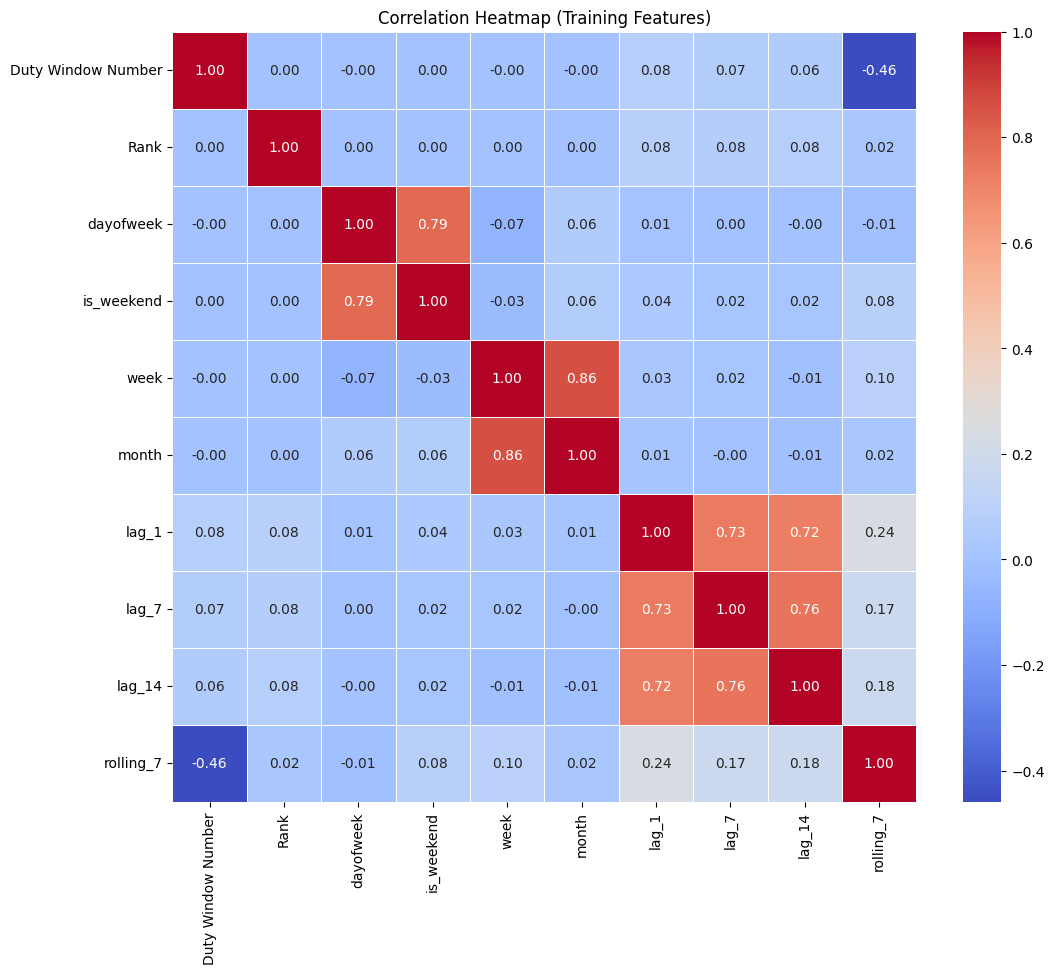

In [26]:
#// filepath: c:\Users\Krishna.x.Jaiswal\Downloads\standby_crew_ml\crew_reqire_prediction_LGBM_REGRESSION.ipynb
# STEP 14: Correlation Heatmap of Features (train set)
correlation_matrix = X_train.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5
)
plt.title('Correlation Heatmap (Training Features)')
plt.show()

In [27]:
#// filepath: c:\Users\Krishna.x.Jaiswal\Downloads\standby_crew_ml\crew_reqire_prediction_LGBM_REGRESSION.ipynb
# STEP 15: Next-day prediction per group using tuned model
last_known_date = df_model['Date'].max()
next_day_date = last_known_date + timedelta(days=1)

unique_groups = df_model[['Station', 'Duty Window Number', 'Rank']].drop_duplicates().copy()

future_predictions_input = pd.DataFrame(unique_groups)
future_predictions_input['Date'] = next_day_date

future_predictions_input['dayofweek'] = future_predictions_input['Date'].dt.dayofweek
future_predictions_input['is_weekend'] = future_predictions_input['dayofweek'].isin([5,6]).astype(int)
future_predictions_input['week'] = future_predictions_input['Date'].dt.isocalendar().week.astype(int)
future_predictions_input['month'] = future_predictions_input['Date'].dt.month

lag_rolling_data = []
for _, row in future_predictions_input.iterrows():
    station, duty_window_number, rank = row['Station'], row['Duty Window Number'], row['Rank']

    group_history = df_model[
        (df_model['Station'] == station) &
        (df_model['Duty Window Number'] == duty_window_number) &
        (df_model['Rank'] == rank)
    ].sort_values('Date').set_index('Date')

    lag_1_val = group_history.loc[last_known_date, TARGET_COL] if last_known_date in group_history.index else np.nan

    date_for_lag7 = last_known_date - timedelta(days=6)
    lag_7_val = group_history.loc[date_for_lag7, TARGET_COL] if date_for_lag7 in group_history.index else np.nan

    date_for_lag14 = last_known_date - timedelta(days=13)
    lag_14_val = group_history.loc[date_for_lag14, TARGET_COL] if date_for_lag14 in group_history.index else np.nan

    rolling_7_window_start = last_known_date - timedelta(days=6)
    rolling_7_series = group_history.loc[rolling_7_window_start:last_known_date, TARGET_COL]
    rolling_7_val = rolling_7_series.mean() if len(rolling_7_series) == 7 else np.nan

    lag_rolling_data.append({
        'Station': station,
        'Duty Window Number': duty_window_number,
        'Rank': rank,
        'lag_1': lag_1_val,
        'lag_7': lag_7_val,
        'lag_14': lag_14_val,
        'rolling_7': rolling_7_val
    })

future_predictions_input = pd.merge(
    future_predictions_input,
    pd.DataFrame(lag_rolling_data),
    on=['Station', 'Duty Window Number', 'Rank'],
    how='left'
)

X_next_day_predict = future_predictions_input[features].copy()
X_next_day_predict.dropna(inplace=True)

if not X_next_day_predict.empty:
    predictions = best_model.predict(X_next_day_predict)
    future_predictions_input.loc[X_next_day_predict.index, 'Predicted_Standby_Activation_Count'] = predictions.round().astype(int)

    print(f"Predicted Standby Activation Count for {next_day_date.strftime('%Y-%m-%d')}:")
    display(future_predictions_input[['Station', 'Duty Window Number', 'Rank', 'Predicted_Standby_Activation_Count']].sort_values(['Station', 'Duty Window Number', 'Rank']))
else:
    print("Could not generate predictions for the next day due to insufficient history.")

Predicted Standby Activation Count for 2025-10-01:


,Station,Duty Window Number,Rank,Predicted_Standby_Activation_Count
9,DEL,1,0,2.0
10,DEL,1,1,2.0
8,DEL,2,0,12.0
6,DEL,2,1,13.0
11,DEL,3,0,11.0
7,DEL,3,1,11.0
0,DEL,4,0,14.0
5,DEL,4,1,14.0
3,DEL,5,0,10.0
4,DEL,5,1,12.0


In [28]:
#// filepath: c:\Users\Krishna.x.Jaiswal\Downloads\standby_crew_ml\crew_reqire_prediction_LGBM_REGRESSION.ipynb
# STEP 16: Save next-day predictions to CSV
output_df = future_predictions_input[[
    'Station',
    'Duty Window Number',
    'Rank',
    'Predicted_Standby_Activation_Count'
]].copy()

output_csv_path = 'next_day_standby_activation_predictions.csv'
output_df.to_csv(output_csv_path, index=False)

print(f"Predictions saved to {output_csv_path}")
display(output_df.head())

Predictions saved to next_day_standby_activation_predictions.csv


,Station,Duty Window Number,Rank,Predicted_Standby_Activation_Count
0,DEL,4,0,14.0
1,DEL,6,0,5.0
2,DEL,6,1,6.0
3,DEL,5,0,10.0
4,DEL,5,1,12.0


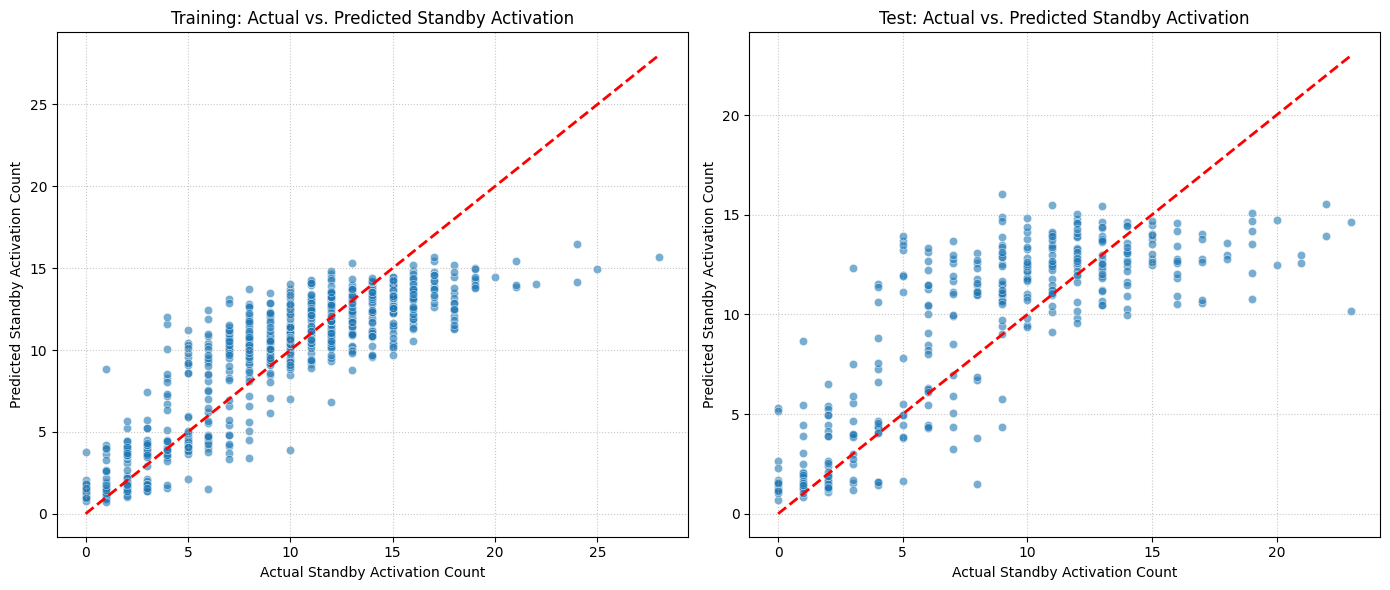

In [29]:
#// filepath: c:\Users\Krishna.x.Jaiswal\Downloads\standby_crew_ml\crew_reqire_prediction_LGBM_REGRESSION.ipynb
# STEP 17: Scatter plots (Actual vs Predicted)
y_train_pred_tuned = best_model.predict(X_train)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y=y_train_pred_tuned, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.title('Training: Actual vs. Predicted Standby Activation')
plt.xlabel('Actual Standby Activation Count')
plt.ylabel('Predicted Standby Activation Count')
plt.grid(True, linestyle=':', alpha=0.7)

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=pred_tuned, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Test: Actual vs. Predicted Standby Activation')
plt.xlabel('Actual Standby Activation Count')
plt.ylabel('Predicted Standby Activation Count')
plt.grid(True, linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()

In [30]:
#// filepath: c:\Users\Krishna.x.Jaiswal\Downloads\standby_crew_ml\crew_reqire_prediction_LGBM_REGRESSION.ipynb
# STEP 18: Install dependencies for TCN
%pip install -q tensorflow tcn

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tcn (from versions: none)
ERROR: No matching distribution found for tcn


In [31]:
# STEP 18.1: TCN Forecasting Model Implementation
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

c:\Users\Krishna.x.Jaiswal\Downloads\standby_crew_ml\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [32]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("🔧 Building TCN Forecasting Model...")

# Configuration for TCN
WINDOW_SIZE = 14  # Look back 14 days
GROUP_COLS = ['Station', 'Duty Window Number', 'Rank']
TARGET_COL = 'Standby Activation Count'

# TCN Features (time series features)
TCN_FEATURES = [
    'Standby Activation Count',  # Target (lagged)
    'dayofweek', 
    'is_weekend', 
    'week', 
    'month'
]


🔧 Building TCN Forecasting Model...


In [33]:
def create_sequences(df, window_size, target_col, feature_cols, group_cols):
    """Create sequences for TCN training"""
    X_sequences = []
    y_sequences = []
    group_info = []
    date_info = []
    
    for group_key, group_df in df.groupby(group_cols):
        group_df = group_df.sort_values('Date').reset_index(drop=True)
        
        # Skip groups with insufficient data
        if len(group_df) <= window_size:
            continue
            
        # Extract features and target
        feature_data = group_df[feature_cols].values
        target_data = group_df[target_col].values
        dates = group_df['Date'].values
        
        # Create sequences
        for i in range(window_size, len(group_df)):
            # Features: previous window_size time steps
            X_sequences.append(feature_data[i-window_size:i])
            # Target: current time step
            y_sequences.append(target_data[i])
            # Metadata
            group_info.append(group_key)
            date_info.append(dates[i])
    
    if len(X_sequences) == 0:
        return None, None, None, None
        
    X = np.array(X_sequences, dtype=np.float32)
    y = np.array(y_sequences, dtype=np.float32)
    
    return X, y, group_info, date_info

In [34]:
# Build TCN dataset
print("📊 Creating TCN sequences...")
X_tcn, y_tcn, groups_tcn, dates_tcn = create_sequences(
    df_model, 
    WINDOW_SIZE, 
    TARGET_COL, 
    TCN_FEATURES, 
    GROUP_COLS
)

📊 Creating TCN sequences...


In [35]:
if X_tcn is None:
    print("❌ Failed to create TCN sequences. Check data availability.")
else:
    print(f"✅ Created {len(X_tcn)} sequences")
    print(f"📐 Sequence shape: {X_tcn.shape}")
    
    # Convert dates to pandas datetime for easier filtering
    dates_tcn = pd.to_datetime(dates_tcn)
    
    # Apply same train-test split as LightGBM
    split_date_dt = pd.to_datetime('2025-08-31')
    train_mask = dates_tcn <= split_date_dt
    test_mask = dates_tcn > split_date_dt
    
    X_train_tcn = X_tcn[train_mask]
    X_test_tcn = X_tcn[test_mask]
    y_train_tcn = y_tcn[train_mask]
    y_test_tcn = y_tcn[test_mask]
    
    print(f"📊 TCN Train shape: {X_train_tcn.shape}")
    print(f"📊 TCN Test shape: {X_test_tcn.shape}")


✅ Created 924 sequences
📐 Sequence shape: (924, 14, 5)
📊 TCN Train shape: (564, 14, 5)
📊 TCN Test shape: (360, 14, 5)


In [36]:
if len(X_train_tcn) < 10:
        print("⚠️ Insufficient training data for TCN. Need more historical data.")
else:
        # Normalize features for better training
        scaler = StandardScaler()
        X_train_tcn_scaled = scaler.fit_transform(X_train_tcn.reshape(-1, X_train_tcn.shape[-1])).reshape(X_train_tcn.shape)
        X_test_tcn_scaled = scaler.transform(X_test_tcn.reshape(-1, X_test_tcn.shape[-1])).reshape(X_test_tcn.shape)
        

In [37]:
#Build TCN Architecture
n_features = X_train_tcn.shape[-1]

def build_tcn_model(input_shape):
    """Build TCN model for time series forecasting"""
    inputs = keras.Input(shape=input_shape, name='tcn_input')

    # TCN layers with different dilation rates for multi-scale patterns
    x = layers.Conv1D(64, 3, padding='causal', activation='relu', dilation_rate=1)(inputs)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv1D(64, 3, padding='causal', activation='relu', dilation_rate=2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv1D(64, 3, padding='causal', activation='relu', dilation_rate=4)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv1D(32, 3, padding='causal', activation='relu', dilation_rate=8)(x)
    x = layers.Dropout(0.2)(x)

    # Global pooling and dense layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation='relu')(x)

    # Output layer
    outputs = layers.Dense(1, activation='relu')(x)  # Non-negative predictions

    model = keras.Model(inputs, outputs)
    return model

In [38]:
# Create and compile model
tcn_model = build_tcn_model((WINDOW_SIZE, n_features))
tcn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='huber',  # Robust to outliers
    metrics=['mae']
)

In [39]:
print("🏗️ TCN Model Architecture:")
tcn_model.summary()

🏗️ TCN Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn_input (InputLayer)          │ (None, 14, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 14, 64)         │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 14, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 14, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 14, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,129 (141.13 KB)

 Trainable params: 36,129 (141.13 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:

# Training configuration
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

In [41]:
# Train the model
print("🚀 Training TCN model...")
history = tcn_model.fit(
    X_train_tcn_scaled, y_train_tcn,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

🚀 Training TCN model...
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 8.6384 - mae: 9.1200 - val_loss: 3.0953 - val_mae: 3.5515 - learning_rate: 0.0010
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6901 - mae: 5.1734 - val_loss: 2.4021 - val_mae: 2.8617 - learning_rate: 0.0010
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7871 - mae: 3.2574 - val_loss: 1.7074 - val_mae: 2.1614 - learning_rate: 0.0010
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.6286 - mae: 3.1016 - val_loss: 1.7188 - val_mae: 2.1659 - learning_rate: 0.0010
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4198 - mae: 2.8806 - val_loss: 1.9147 - val_mae: 2.3787 - learning_rate: 0.0010
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3536 - mae: 2.8141 - val_loss: 1.8577 - val_mae: 2.3236 - learning_rate: 0.0010
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3941 - mae: 2.8516 - val_loss: 1.8232 - val_mae: 2.2765 - learning_r

In [42]:
# Generate predictions for train and test sets using the trained TCN model
pred_train_tcn = tcn_model.predict(X_train_tcn_scaled, verbose=0).flatten()
pred_test_tcn = tcn_model.predict(X_test_tcn_scaled, verbose=0).flatten()

# Training metrics
mae_train_tcn = mean_absolute_error(y_train_tcn, pred_train_tcn)
rmse_train_tcn = np.sqrt(mean_squared_error(y_train_tcn, pred_train_tcn))
mape_train_tcn = mean_absolute_percentage_error(y_train_tcn, pred_train_tcn)
acc_20pct_train_tcn = accuracy_within_threshold(y_train_tcn, pred_train_tcn, 20)

# Test metrics
mae_test_tcn = mean_absolute_error(y_test_tcn, pred_test_tcn)
rmse_test_tcn = np.sqrt(mean_squared_error(y_test_tcn, pred_test_tcn))
mape_test_tcn = mean_absolute_percentage_error(y_test_tcn, pred_test_tcn)
wape_test_tcn = weighted_absolute_percentage_error(y_test_tcn, pred_test_tcn)
smape_test_tcn = symmetric_mean_absolute_percentage_error(y_test_tcn, pred_test_tcn)
nrmse_test_tcn = normalized_rmse_percentage(y_test_tcn, pred_test_tcn)
acc_10pct_test_tcn = accuracy_within_threshold(y_test_tcn, pred_test_tcn, 10)
acc_20pct_test_tcn = accuracy_within_threshold(y_test_tcn, pred_test_tcn, 20)
acc_30pct_test_tcn = accuracy_within_threshold(y_test_tcn, pred_test_tcn, 30)

print("\n📊 Training Performance:")
print(f"MAE: {mae_train_tcn:.2f}")
print(f"RMSE: {rmse_train_tcn:.2f}")
print(f"MAPE: {mape_train_tcn:.1f}%")
print(f"Accuracy within 20%: {acc_20pct_train_tcn:.1f}%")

print("\n📊 Test Performance:")
print(f"MAE: {mae_test_tcn:.2f}")
print(f"RMSE: {rmse_test_tcn:.2f}")

print("\n📈 Percentage-Based Metrics:")
print(f"MAPE: {mape_test_tcn:.1f}%")
print(f"WAPE: {wape_test_tcn:.1f}%")
print(f"sMAPE: {smape_test_tcn:.1f}%")
print(f"NRMSE: {nrmse_test_tcn:.1f}%")

print("\n📊 Business-Friendly Accuracy:")
print(f"Accuracy within 10%: {acc_10pct_test_tcn:.1f}%")
print(f"Accuracy within 20%: {acc_20pct_test_tcn:.1f}%")
print(f"Accuracy within 30%: {acc_30pct_test_tcn:.1f}%")



📊 Training Performance:
MAE: 2.73
RMSE: 3.37
MAPE: 57.1%
Accuracy within 20%: 36.9%

📊 Test Performance:
MAE: 9.40
RMSE: 10.22

📈 Percentage-Based Metrics:
MAPE: 200.1%
WAPE: 109.1%
sMAPE: 82.3%
NRMSE: 118.7%

📊 Business-Friendly Accuracy:
Accuracy within 10%: 2.8%
Accuracy within 20%: 5.8%
Accuracy within 30%: 7.8%


In [43]:
#Compare with LGBM if available
if 'mape_tuned' in globals():
    print("\n🔄 TCN vs Tuned LGBM Comparison:")
    mape_diff = mape_test_tcn - mape_tuned
    acc_diff = acc_20pct_test_tcn - acc_20pct_tuned
    
    print(f"MAPE Difference: {mape_diff:+.1f} percentage points")
    print(f"Accuracy (20%) Difference: {acc_diff:+.1f} percentage points")
    
    if abs(mape_diff) < 2.0:
        print("🔄 Similar performance (difference < 2%)")
    elif mape_test_tcn < mape_tuned:
        print("✅ TCN performs better (lower MAPE)")
    else:
        print("⚠️  LGBM performs better (lower MAPE)")

# Performance assessment
print("\n🎯 TCN Performance Assessment:")
if mape_test_tcn < 15:
    print("✅ Excellent: MAPE < 15%")
elif mape_test_tcn < 25:
    print("✅ Good: MAPE < 25%")
elif mape_test_tcn < 35:
    print("⚠️  Fair: MAPE < 35%")
else:
    print("❌ Poor: MAPE >= 35%")
    
if acc_20pct_test_tcn >= 80:
    print("✅ High Accuracy: >80% predictions within 20% range")
elif acc_20pct_test_tcn >= 60:
    print("✅ Good Accuracy: >60% predictions within 20% range")
elif acc_20pct_test_tcn >= 40:
    print("⚠️  Fair Accuracy: >40% predictions within 20% range")
else:
    print("❌ Low Accuracy: <40% predictions within 20% range")

print(f"\n📊 Final TCN Summary: MAPE = {mape_test_tcn:.1f}% | Accuracy@20% = {acc_20pct_test_tcn:.1f}%")

# Store variables for next step forecasting
globals()['tcn_model'] = tcn_model
globals()['scaler_tcn'] = scaler
globals()['pred_test_tcn'] = pred_test_tcn
globals()['WINDOW_SIZE'] = WINDOW_SIZE
globals()['TCN_FEATURES'] = TCN_FEATURES

print("\n✅ TCN model trained successfully and ready for forecasting!")


🔄 TCN vs Tuned LGBM Comparison:
MAPE Difference: +157.4 percentage points
Accuracy (20%) Difference: -32.8 percentage points
⚠️  LGBM performs better (lower MAPE)

🎯 TCN Performance Assessment:
❌ Poor: MAPE >= 35%
❌ Low Accuracy: <40% predictions within 20% range

📊 Final TCN Summary: MAPE = 200.1% | Accuracy@20% = 5.8%

✅ TCN model trained successfully and ready for forecasting!


In [44]:
# STEP 18.2: TCN Next-Day Forecasting
print("🔮 Generating TCN Next-Day Predictions...")

if 'tcn_model' in globals() and 'scaler_tcn' in globals():
    # Get the last known date and calculate next day
    last_known_date = df_model['Date'].max()
    next_day_date = last_known_date + timedelta(days=1)
    
    print(f"📅 Last known date: {last_known_date.strftime('%Y-%m-%d')}")
    print(f"🎯 Predicting for: {next_day_date.strftime('%Y-%m-%d')}")
    
    # Prepare next-day features (same time features as next_day_date)
    next_day_features = {
        'dayofweek': next_day_date.dayofweek,
        'is_weekend': 1 if next_day_date.dayofweek in [5, 6] else 0,
        'week': next_day_date.isocalendar().week,
        'month': next_day_date.month
    }
    
    tcn_predictions = []
    
    for group_key, group_df in df_model.groupby(GROUP_COLS):
        group_df = group_df.sort_values('Date')
        
        # Skip groups with insufficient history
        if len(group_df) < WINDOW_SIZE:
            continue
            
        # Get the last WINDOW_SIZE records for this group
        recent_data = group_df.tail(WINDOW_SIZE).copy()
        
        # Prepare the sequence for prediction
        sequence_data = []
        for _, row in recent_data.iterrows():
            feature_vector = [
                row[TARGET_COL],  # Previous activation count
                row['dayofweek'],
                row['is_weekend'],
                row['week'],
                row['month']
            ]
            sequence_data.append(feature_vector)
        
        # Ensure we have exactly WINDOW_SIZE time steps
        if len(sequence_data) == WINDOW_SIZE:
            # Convert to numpy array and add batch dimension
            X_pred = np.array(sequence_data, dtype=np.float32).reshape(1, WINDOW_SIZE, -1)
            
            # Scale the features
            X_pred_scaled = scaler_tcn.transform(X_pred.reshape(-1, X_pred.shape[-1])).reshape(X_pred.shape)
            
            # Make prediction
            pred = tcn_model.predict(X_pred_scaled, verbose=0)[0, 0]
            pred = max(0, pred)  # Ensure non-negative prediction
            
            # Store prediction
            station, duty_window, rank = group_key
            tcn_predictions.append({
                'Date': next_day_date,
                'Station': station,
                'Duty Window Number': duty_window,
                'Rank': rank,
                'Predicted_Standby_Activation_Count': int(round(pred))
            })
    
    # Create DataFrame with predictions
    tcn_pred_df = pd.DataFrame(tcn_predictions)
    
    if not tcn_pred_df.empty:
        tcn_pred_df = tcn_pred_df.sort_values(['Station', 'Duty Window Number', 'Rank'])
        
        print(f"\n📊 TCN Predictions for {next_day_date.strftime('%Y-%m-%d')}:")
        print(f"📈 Generated {len(tcn_pred_df)} predictions")
        
        display(tcn_pred_df)
        
        # Save to CSV
        tcn_output_path = 'next_day_tcn_predictions.csv'
        tcn_pred_df.to_csv(tcn_output_path, index=False)
        print(f"💾 Saved TCN predictions to: {tcn_output_path}")
        
        # Compare with LGBM predictions if available
        if 'output_df' in globals():
            print(f"\n🔄 Comparison with LGBM Predictions:")
            
            # Merge predictions for comparison
            lgbm_pred = globals()['output_df'].copy()
            lgbm_pred.columns = ['Station', 'Duty Window Number', 'Rank', 'LGBM_Prediction']
            
            comparison_df = pd.merge(
                tcn_pred_df[['Station', 'Duty Window Number', 'Rank', 'Predicted_Standby_Activation_Count']],
                lgbm_pred,
                on=['Station', 'Duty Window Number', 'Rank'],
                how='outer'
            )
            comparison_df = comparison_df.rename(columns={
                'Predicted_Standby_Activation_Count': 'TCN_Prediction'
            })
            
            # Calculate differences
            comparison_df['Difference'] = comparison_df['TCN_Prediction'] - comparison_df['LGBM_Prediction']
            comparison_df['Abs_Difference'] = comparison_df['Difference'].abs()
            comparison_df['Percent_Difference'] = (
                comparison_df['Difference'] / comparison_df['LGBM_Prediction'] * 100
            ).round(1)
            
            print("📊 Prediction Comparison Summary:")
            print(f"Mean Absolute Difference: {comparison_df['Abs_Difference'].mean():.2f}")
            print(f"Max Absolute Difference: {comparison_df['Abs_Difference'].max():.2f}")
            print(f"Mean Percent Difference: {comparison_df['Percent_Difference'].abs().mean():.1f}%")
            
            # Show top differences
            print(f"\n🔍 Top 5 Largest Differences:")
            top_diff = comparison_df.nlargest(5, 'Abs_Difference')[
                ['Station', 'Duty Window Number', 'Rank', 'TCN_Prediction', 'LGBM_Prediction', 'Difference']
            ]
            display(top_diff)
            
            # Save comparison
            comparison_path = 'tcn_vs_lgbm_comparison.csv'
            comparison_df.to_csv(comparison_path, index=False)
            print(f"💾 Saved comparison to: {comparison_path}")
        
        # Summary statistics
        print(f"\n📈 TCN Prediction Statistics:")
        print(f"Mean prediction: {tcn_pred_df['Predicted_Standby_Activation_Count'].mean():.2f}")
        print(f"Median prediction: {tcn_pred_df['Predicted_Standby_Activation_Count'].median():.2f}")
        print(f"Min prediction: {tcn_pred_df['Predicted_Standby_Activation_Count'].min()}")
        print(f"Max prediction: {tcn_pred_df['Predicted_Standby_Activation_Count'].max()}")
        print(f"Standard deviation: {tcn_pred_df['Predicted_Standby_Activation_Count'].std():.2f}")
        
    else:
        print("⚠️  No TCN predictions generated. Check data availability and window size.")
        
else:
    print("❌ TCN model not available. Please run the TCN training step first.")

🔮 Generating TCN Next-Day Predictions...
📅 Last known date: 2025-09-30
🎯 Predicting for: 2025-10-01

📊 TCN Predictions for 2025-10-01:
📈 Generated 12 predictions


,Date,Station,Duty Window Number,Rank,Predicted_Standby_Activation_Count
0,2025-10-01,DEL,1,0,16
1,2025-10-01,DEL,1,1,15
2,2025-10-01,DEL,2,0,28
3,2025-10-01,DEL,2,1,29
4,2025-10-01,DEL,3,0,26
5,2025-10-01,DEL,3,1,24
6,2025-10-01,DEL,4,0,25
7,2025-10-01,DEL,4,1,26
8,2025-10-01,DEL,5,0,24
9,2025-10-01,DEL,5,1,25


💾 Saved TCN predictions to: next_day_tcn_predictions.csv

🔄 Comparison with LGBM Predictions:
📊 Prediction Comparison Summary:
Mean Absolute Difference: 13.33
Max Absolute Difference: 16.00
Mean Percent Difference: 224.7%

🔍 Top 5 Largest Differences:


,Station,Duty Window Number,Rank,TCN_Prediction,LGBM_Prediction,Difference
2,DEL,2,0,28,12.0,16.0
3,DEL,2,1,29,13.0,16.0
4,DEL,3,0,26,11.0,15.0
0,DEL,1,0,16,2.0,14.0
8,DEL,5,0,24,10.0,14.0


💾 Saved comparison to: tcn_vs_lgbm_comparison.csv

📈 TCN Prediction Statistics:
Mean prediction: 22.67
Median prediction: 24.50
Min prediction: 15
Max prediction: 29
Standard deviation: 4.98


In [45]:
!pip install xgboost

In [46]:
# STEP 19: XGBoost Model Implementation and Training
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [47]:

# XGBoost baseline model (similar parameters to LightGBM)
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)


In [48]:
print("📊 Training XGBoost baseline model...")
xgb_model.fit(X_train, y_train)

📊 Training XGBoost baseline model...


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [49]:

# Make baseline predictions
pred_xgb_baseline = xgb_model.predict(X_test)

In [50]:

# Baseline evaluation
mae_xgb_baseline = mean_absolute_error(y_test, pred_xgb_baseline)
rmse_xgb_baseline = np.sqrt(mean_squared_error(y_test, pred_xgb_baseline))
mape_xgb_baseline = mean_absolute_percentage_error(y_test, pred_xgb_baseline)
wape_xgb_baseline = weighted_absolute_percentage_error(y_test, pred_xgb_baseline)
smape_xgb_baseline = symmetric_mean_absolute_percentage_error(y_test, pred_xgb_baseline)
nrmse_xgb_baseline = normalized_rmse_percentage(y_test, pred_xgb_baseline)
acc_10pct_xgb_baseline = accuracy_within_threshold(y_test, pred_xgb_baseline, 10)
acc_20pct_xgb_baseline = accuracy_within_threshold(y_test, pred_xgb_baseline, 20)
acc_30pct_xgb_baseline = accuracy_within_threshold(y_test, pred_xgb_baseline, 30)

print("\n" + "="*60)
print("🌟 XGBOOST BASELINE MODEL EVALUATION")
print("="*60)

print("\n📊 Traditional Metrics:")
print(f"MAE: {mae_xgb_baseline:.2f}")
print(f"RMSE: {rmse_xgb_baseline:.2f}")

print("\n📈 Percentage-Based Metrics:")
print(f"MAPE: {mape_xgb_baseline:.1f}%")
print(f"WAPE: {wape_xgb_baseline:.1f}%")
print(f"sMAPE: {smape_xgb_baseline:.1f}%")
print(f"NRMSE: {nrmse_xgb_baseline:.1f}%")

print("\n📊 Business-Friendly Accuracy:")
print(f"Accuracy within 10%: {acc_10pct_xgb_baseline:.1f}%")
print(f"Accuracy within 20%: {acc_20pct_xgb_baseline:.1f}%")
print(f"Accuracy within 30%: {acc_30pct_xgb_baseline:.1f}%")


🌟 XGBOOST BASELINE MODEL EVALUATION

📊 Traditional Metrics:
MAE: 2.70
RMSE: 3.61

📈 Percentage-Based Metrics:
MAPE: 47.7%
WAPE: 31.3%
sMAPE: 42.3%
NRMSE: 41.9%

📊 Business-Friendly Accuracy:
Accuracy within 10%: 20.0%
Accuracy within 20%: 36.4%
Accuracy within 30%: 50.8%


In [51]:
# Hyperparameter tuning for XGBoost
print("\n🔧 Starting XGBoost hyperparameter tuning...")

xgb_param_grid = {
    'n_estimators': [300, 500, 700],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}


🔧 Starting XGBoost hyperparameter tuning...


In [52]:
xgb_base = xgb.XGBRegressor(random_state=42, n_jobs=-1)

xgb_grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=xgb_param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

In [53]:



print("⏳ Training XGBoost with grid search (this may take a while)...")
xgb_grid_search.fit(X_train, y_train)

print(f"\n✅ Best XGBoost parameters: {xgb_grid_search.best_params_}")
print(f"✅ Best cross-validation MAE: {-xgb_grid_search.best_score_:.2f}")

# Get the best XGBoost model
best_xgb_model = xgb_grid_search.best_estimator_

⏳ Training XGBoost with grid search (this may take a while)...
Fitting 3 folds for each of 19683 candidates, totalling 59049 fits

✅ Best XGBoost parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 500, 'reg_alpha': 0, 'reg_lambda': 1.5, 'subsample': 1.0}
✅ Best cross-validation MAE: 2.36


In [54]:
# STEP 20: XGBoost Tuned Model Evaluation
print("📈 Evaluating tuned XGBoost model...")

# Make predictions with tuned model
pred_xgb_tuned = best_xgb_model.predict(X_test)

# Calculate comprehensive metrics for tuned model
mae_xgb_tuned = mean_absolute_error(y_test, pred_xgb_tuned)
rmse_xgb_tuned = np.sqrt(mean_squared_error(y_test, pred_xgb_tuned))
mape_xgb_tuned = mean_absolute_percentage_error(y_test, pred_xgb_tuned)
wape_xgb_tuned = weighted_absolute_percentage_error(y_test, pred_xgb_tuned)
smape_xgb_tuned = symmetric_mean_absolute_percentage_error(y_test, pred_xgb_tuned)
nrmse_xgb_tuned = normalized_rmse_percentage(y_test, pred_xgb_tuned)
acc_10pct_xgb_tuned = accuracy_within_threshold(y_test, pred_xgb_tuned, 10)
acc_20pct_xgb_tuned = accuracy_within_threshold(y_test, pred_xgb_tuned, 20)
acc_30pct_xgb_tuned = accuracy_within_threshold(y_test, pred_xgb_tuned, 30)

print("\n" + "="*60)
print("🌟 XGBOOST TUNED MODEL EVALUATION")
print("="*60)

print("\n📊 Traditional Metrics:")
print(f"MAE: {mae_xgb_tuned:.2f}")
print(f"RMSE: {rmse_xgb_tuned:.2f}")

print("\n📈 Percentage-Based Metrics:")
print(f"MAPE: {mape_xgb_tuned:.1f}%")
print(f"WAPE: {wape_xgb_tuned:.1f}%")
print(f"sMAPE: {smape_xgb_tuned:.1f}%")
print(f"NRMSE: {nrmse_xgb_tuned:.1f}%")

print("\n📊 Business-Friendly Accuracy:")
print(f"Accuracy within 10%: {acc_10pct_xgb_tuned:.1f}%")
print(f"Accuracy within 20%: {acc_20pct_xgb_tuned:.1f}%")
print(f"Accuracy within 30%: {acc_30pct_xgb_tuned:.1f}%")

# Model improvement comparison (baseline vs tuned XGBoost)
print("\n🔄 XGBoost Model Improvement (Baseline → Tuned):")
mae_improvement_xgb = ((mae_xgb_baseline - mae_xgb_tuned) / mae_xgb_baseline) * 100
rmse_improvement_xgb = ((rmse_xgb_baseline - rmse_xgb_tuned) / rmse_xgb_baseline) * 100
mape_improvement_xgb = mape_xgb_baseline - mape_xgb_tuned
acc_improvement_xgb = acc_20pct_xgb_tuned - acc_20pct_xgb_baseline

print(f"MAE Improvement: {mae_improvement_xgb:+.1f}%")
print(f"RMSE Improvement: {rmse_improvement_xgb:+.1f}%")
print(f"MAPE Improvement: {mape_improvement_xgb:+.1f} percentage points")
print(f"Accuracy (20%) Improvement: {acc_improvement_xgb:+.1f} percentage points")

📈 Evaluating tuned XGBoost model...

🌟 XGBOOST TUNED MODEL EVALUATION

📊 Traditional Metrics:
MAE: 2.51
RMSE: 3.33

📈 Percentage-Based Metrics:
MAPE: 43.1%
WAPE: 29.1%
sMAPE: 37.9%
NRMSE: 38.6%

📊 Business-Friendly Accuracy:
Accuracy within 10%: 20.6%
Accuracy within 20%: 40.6%
Accuracy within 30%: 58.6%

🔄 XGBoost Model Improvement (Baseline → Tuned):
MAE Improvement: +7.0%
RMSE Improvement: +7.8%
MAPE Improvement: +4.6 percentage points
Accuracy (20%) Improvement: +4.2 percentage points


In [55]:
# Compare with LightGBM and TCN if available
print("\n🔄 MODEL COMPARISON SUMMARY:")
print("="*40)

models_comparison = []

# LightGBM comparison
if 'mape_tuned' in globals():
    models_comparison.append({
        'Model': 'LightGBM (Tuned)',
        'MAPE': f"{mape_tuned:.1f}%",
        'Accuracy@20%': f"{acc_20pct_tuned:.1f}%",
        'MAE': f"{mae_tuned:.2f}",
        'RMSE': f"{rmse_tuned:.2f}"
    })

# XGBoost comparison
models_comparison.append({
    'Model': 'XGBoost (Tuned)',
    'MAPE': f"{mape_xgb_tuned:.1f}%",
    'Accuracy@20%': f"{acc_20pct_xgb_tuned:.1f}%",
    'MAE': f"{mae_xgb_tuned:.2f}",
    'RMSE': f"{rmse_xgb_tuned:.2f}"
})

# TCN comparison
if 'mape_test_tcn' in globals():
    models_comparison.append({
        'Model': 'TCN',
        'MAPE': f"{mape_test_tcn:.1f}%",
        'Accuracy@20%': f"{acc_20pct_test_tcn:.1f}%",
        'MAE': f"{mae_test_tcn:.2f}",
        'RMSE': f"{rmse_test_tcn:.2f}"
    })

# Display comparison table
comparison_df = pd.DataFrame(models_comparison)
print("\n📊 All Models Performance Comparison:")
display(comparison_df)

# Determine best model
if 'mape_tuned' in globals():
    print(f"\n🏆 BEST MODEL RANKING (by MAPE):")
    
    model_mapes = [
        ('LightGBM', mape_tuned),
        ('XGBoost', mape_xgb_tuned)
    ]
    
    if 'mape_test_tcn' in globals():
        model_mapes.append(('TCN', mape_test_tcn))
    
    # Sort by MAPE (lower is better)
    model_mapes.sort(key=lambda x: x[1])
    
    for i, (model_name, mape_score) in enumerate(model_mapes, 1):
        emoji = "🥇" if i == 1 else "🥈" if i == 2 else "🥉"
        print(f"{emoji} {i}. {model_name}: {mape_score:.1f}% MAPE")
    
    best_model_name = model_mapes[0][0]
    best_model_mape = model_mapes[0][1]
    
    print(f"\n🎯 RECOMMENDATION: {best_model_name} performs best with {best_model_mape:.1f}% MAPE")

# XGBoost performance assessment
print(f"\n🎯 XGBoost Performance Assessment:")
if mape_xgb_tuned < 15:
    print("✅ Excellent: MAPE < 15%")
elif mape_xgb_tuned < 25:
    print("✅ Good: MAPE < 25%")
elif mape_xgb_tuned < 35:
    print("⚠️  Fair: MAPE < 35%")
else:
    print("❌ Poor: MAPE >= 35%")

if acc_20pct_xgb_tuned >= 80:
    print("✅ High Accuracy: >80% predictions within 20% range")
elif acc_20pct_xgb_tuned >= 60:
    print("✅ Good Accuracy: >60% predictions within 20% range")
elif acc_20pct_xgb_tuned >= 40:
    print("⚠️  Fair Accuracy: >40% predictions within 20% range")
else:
    print("❌ Low Accuracy: <40% predictions within 20% range")

print(f"\n📊 Final XGBoost Summary: MAPE = {mape_xgb_tuned:.1f}% | Accuracy@20% = {acc_20pct_xgb_tuned:.1f}%")


🔄 MODEL COMPARISON SUMMARY:

📊 All Models Performance Comparison:


,Model,MAPE,Accuracy@20%,MAE,RMSE
0,LightGBM (Tuned),42.7%,38.6%,2.52,3.31
1,XGBoost (Tuned),43.1%,40.6%,2.51,3.33
2,TCN,200.1%,5.8%,9.40,10.22



🏆 BEST MODEL RANKING (by MAPE):
🥇 1. LightGBM: 42.7% MAPE
🥈 2. XGBoost: 43.1% MAPE
🥉 3. TCN: 200.1% MAPE

🎯 RECOMMENDATION: LightGBM performs best with 42.7% MAPE

🎯 XGBoost Performance Assessment:
❌ Poor: MAPE >= 35%
⚠️  Fair Accuracy: >40% predictions within 20% range

📊 Final XGBoost Summary: MAPE = 43.1% | Accuracy@20% = 40.6%


🔍 Analyzing XGBoost feature importance...

📊 XGBoost Feature Importance:


,feature,importance
7,lag_7,0.409438
8,lag_14,0.205804
6,lag_1,0.140410
0,Duty Window Number,0.129417
9,rolling_7,0.028496
1,Rank,0.024966
5,month,0.023240
4,week,0.018838
2,dayofweek,0.014725
3,is_weekend,0.004666



🔄 Feature Importance Comparison (XGBoost vs LightGBM):


,feature,xgb_importance,lgbm_importance,importance_diff
9,is_weekend,0.004666,0,0.004666
6,month,0.023240,101,-100.976760
5,Rank,0.024966,342,-341.975034
8,dayofweek,0.014725,503,-502.985275
7,week,0.018838,555,-554.981162
1,lag_14,0.205804,738,-737.794196
2,lag_1,0.140410,799,-798.859590
0,lag_7,0.409438,890,-889.590562
3,Duty Window Number,0.129417,1037,-1036.870583
4,rolling_7,0.028496,1132,-1131.971504


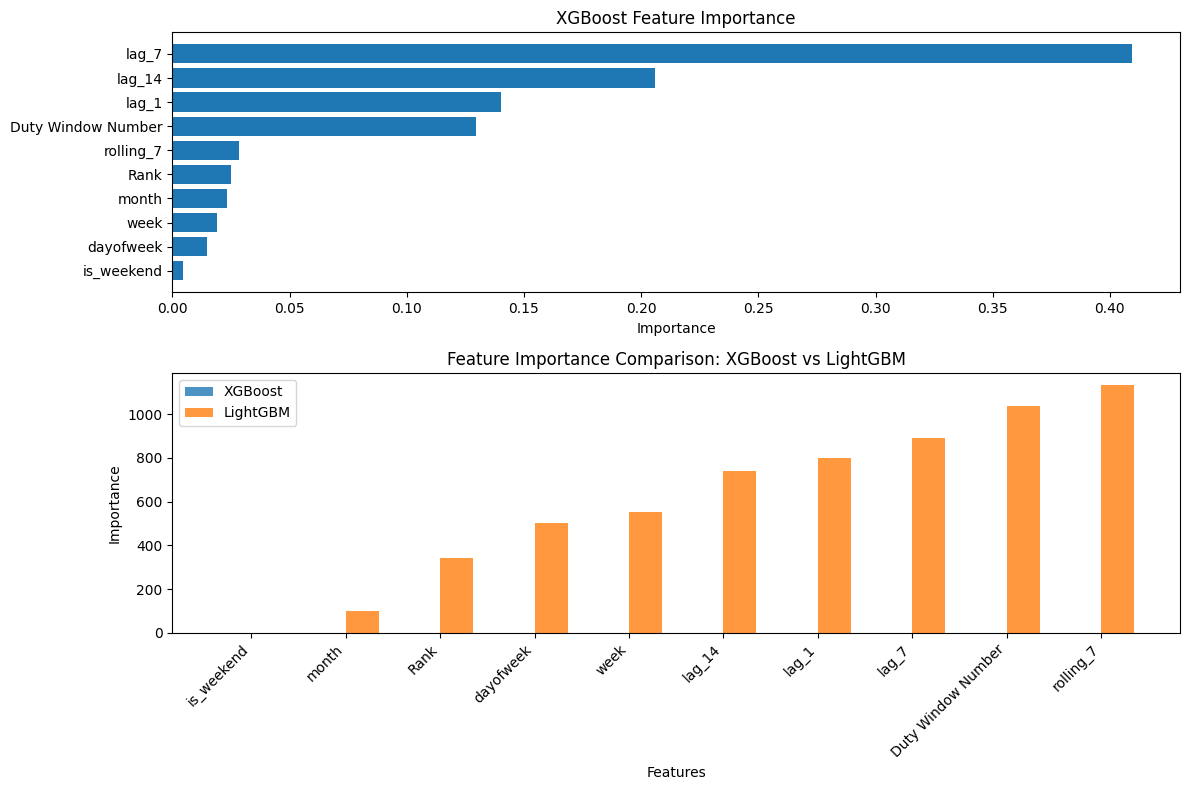

✅ Feature analysis completed!


In [56]:
# STEP 21: XGBoost Feature Importance and Visualization
print("🔍 Analyzing XGBoost feature importance...")

# Get feature importance from tuned XGBoost model
xgb_feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print("\n📊 XGBoost Feature Importance:")
display(xgb_feature_importance)

# Compare feature importance with LightGBM if available
if 'best_model' in globals():
    print("\n🔄 Feature Importance Comparison (XGBoost vs LightGBM):")
    
    lgbm_importance = pd.DataFrame({
        'feature': features,
        'lgbm_importance': best_model.feature_importances_
    })
    
    importance_comparison = pd.merge(
        xgb_feature_importance,
        lgbm_importance,
        on='feature',
        how='inner'
    )
    
    importance_comparison = importance_comparison.rename(columns={
        'importance': 'xgb_importance'
    })
    
    importance_comparison['importance_diff'] = (
        importance_comparison['xgb_importance'] - importance_comparison['lgbm_importance']
    )
    
    importance_comparison = importance_comparison.sort_values('importance_diff', ascending=False)
    
    display(importance_comparison[['feature', 'xgb_importance', 'lgbm_importance', 'importance_diff']])

# Visualization: Feature importance plot
plt.figure(figsize=(12, 8))

# XGBoost feature importance
plt.subplot(2, 1, 1)
plt.barh(xgb_feature_importance['feature'], xgb_feature_importance['importance'])
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.gca().invert_yaxis()

# Comparison plot if LightGBM available
if 'best_model' in globals():
    plt.subplot(2, 1, 2)
    width = 0.35
    x = np.arange(len(features))
    
    plt.bar(x - width/2, importance_comparison['xgb_importance'], 
            width, label='XGBoost', alpha=0.8)
    plt.bar(x + width/2, importance_comparison['lgbm_importance'], 
            width, label='LightGBM', alpha=0.8)
    
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance Comparison: XGBoost vs LightGBM')
    plt.xticks(x, importance_comparison['feature'], rotation=45, ha='right')
    plt.legend()

plt.tight_layout()
plt.show()

print("✅ Feature analysis completed!")

In [57]:
# STEP 22: XGBoost Next-Day Forecasting
print("🔮 Generating XGBoost Next-Day Predictions...")

# Get the last known date and calculate next day (same as other models)
last_known_date = df_model['Date'].max()
next_day_date = last_known_date + timedelta(days=1)

print(f"📅 Last known date: {last_known_date.strftime('%Y-%m-%d')}")
print(f"🎯 Predicting for: {next_day_date.strftime('%Y-%m-%d')}")

# Create future predictions using the same approach as LightGBM
unique_groups = df_model[['Station', 'Duty Window Number', 'Rank']].drop_duplicates().copy()

xgb_future_predictions = pd.DataFrame(unique_groups)
xgb_future_predictions['Date'] = next_day_date

# Add time features for next day
xgb_future_predictions['dayofweek'] = xgb_future_predictions['Date'].dt.dayofweek
xgb_future_predictions['is_weekend'] = xgb_future_predictions['dayofweek'].isin([5,6]).astype(int)
xgb_future_predictions['week'] = xgb_future_predictions['Date'].dt.isocalendar().week.astype(int)
xgb_future_predictions['month'] = xgb_future_predictions['Date'].dt.month

# Calculate lag and rolling features for each group
xgb_lag_rolling_data = []
for _, row in xgb_future_predictions.iterrows():
    station, duty_window_number, rank = row['Station'], row['Duty Window Number'], row['Rank']

    group_history = df_model[
        (df_model['Station'] == station) &
        (df_model['Duty Window Number'] == duty_window_number) &
        (df_model['Rank'] == rank)
    ].sort_values('Date').set_index('Date')

    # Calculate lag features
    lag_1_val = group_history.loc[last_known_date, TARGET_COL] if last_known_date in group_history.index else np.nan

    date_for_lag7 = last_known_date - timedelta(days=6)
    lag_7_val = group_history.loc[date_for_lag7, TARGET_COL] if date_for_lag7 in group_history.index else np.nan

    date_for_lag14 = last_known_date - timedelta(days=13)
    lag_14_val = group_history.loc[date_for_lag14, TARGET_COL] if date_for_lag14 in group_history.index else np.nan

    # Calculate rolling features
    rolling_7_window_start = last_known_date - timedelta(days=6)
    rolling_7_series = group_history.loc[rolling_7_window_start:last_known_date, TARGET_COL]
    rolling_7_val = rolling_7_series.mean() if len(rolling_7_series) == 7 else np.nan

    xgb_lag_rolling_data.append({
        'Station': station,
        'Duty Window Number': duty_window_number,
        'Rank': rank,
        'lag_1': lag_1_val,
        'lag_7': lag_7_val,
        'lag_14': lag_14_val,
        'rolling_7': rolling_7_val
    })

# Merge lag and rolling features
xgb_future_predictions = pd.merge(
    xgb_future_predictions,
    pd.DataFrame(xgb_lag_rolling_data),
    on=['Station', 'Duty Window Number', 'Rank'],
    how='left'
)

# Prepare features for prediction
X_next_day_xgb = xgb_future_predictions[features].copy()
X_next_day_xgb.dropna(inplace=True)

if not X_next_day_xgb.empty:
    # Make predictions with tuned XGBoost model
    xgb_predictions = best_xgb_model.predict(X_next_day_xgb)
    xgb_future_predictions.loc[X_next_day_xgb.index, 'Predicted_Standby_Activation_Count'] = np.round(xgb_predictions).astype(int)

    print(f"\n📊 XGBoost Predictions for {next_day_date.strftime('%Y-%m-%d')}:")
    print(f"📈 Generated {len(X_next_day_xgb)} predictions")
    
    # Display predictions
    xgb_display_df = xgb_future_predictions[
        ['Station', 'Duty Window Number', 'Rank', 'Predicted_Standby_Activation_Count']
    ].sort_values(['Station', 'Duty Window Number', 'Rank'])
    
    display(xgb_display_df)
    
    # Save XGBoost predictions to CSV
    xgb_output_path = 'next_day_xgboost_predictions.csv'
    xgb_display_df.to_csv(xgb_output_path, index=False)
    print(f"💾 Saved XGBoost predictions to: {xgb_output_path}")
    
    # Comprehensive comparison with other models
    print(f"\n🔄 COMPREHENSIVE MODEL PREDICTIONS COMPARISON:")
    print("="*60)
    
    # Prepare comparison dataframe
    all_predictions = xgb_display_df.copy()
    all_predictions = all_predictions.rename(columns={'Predicted_Standby_Activation_Count': 'XGBoost_Prediction'})
    
    # Add LightGBM predictions if available
    if 'output_df' in globals():
        lgbm_pred = globals()['output_df'][['Station', 'Duty Window Number', 'Rank', 'Predicted_Standby_Activation_Count']].copy()
        lgbm_pred = lgbm_pred.rename(columns={'Predicted_Standby_Activation_Count': 'LGBM_Prediction'})
        all_predictions = pd.merge(all_predictions, lgbm_pred, 
                                 on=['Station', 'Duty Window Number', 'Rank'], how='outer')
    
    # Add TCN predictions if available
    if 'tcn_pred_df' in globals():
        tcn_pred = globals()['tcn_pred_df'][['Station', 'Duty Window Number', 'Rank', 'Predicted_Standby_Activation_Count']].copy()
        tcn_pred = tcn_pred.rename(columns={'Predicted_Standby_Activation_Count': 'TCN_Prediction'})
        all_predictions = pd.merge(all_predictions, tcn_pred,
                                 on=['Station', 'Duty Window Number', 'Rank'], how='outer')
    
    print("📊 All Model Predictions Comparison:")
    display(all_predictions.head(10))
    
    # Calculate prediction statistics and differences
    prediction_cols = [col for col in all_predictions.columns if 'Prediction' in col]
    
    if len(prediction_cols) > 1:
        print("\n📈 Prediction Statistics Summary:")
        stats_summary = []
        
        for col in prediction_cols:
            model_name = col.replace('_Prediction', '')
            preds = all_predictions[col].dropna()
            
            stats_summary.append({
                'Model': model_name,
                'Mean': f"{preds.mean():.2f}",
                'Median': f"{preds.median():.2f}",
                'Std': f"{preds.std():.2f}",
                'Min': f"{preds.min():.0f}",
                'Max': f"{preds.max():.0f}",
                'Count': len(preds)
            })
        
        stats_df = pd.DataFrame(stats_summary)
        display(stats_df)
        
        # Calculate differences between models
        if 'LGBM_Prediction' in all_predictions.columns:
            all_predictions['XGB_vs_LGBM'] = all_predictions['XGBoost_Prediction'] - all_predictions['LGBM_Prediction']
            print(f"\n🔍 XGBoost vs LightGBM Differences:")
            print(f"Mean Absolute Difference: {all_predictions['XGB_vs_LGBM'].abs().mean():.2f}")
            print(f"Max Absolute Difference: {all_predictions['XGB_vs_LGBM'].abs().max():.2f}")
            
            # Show largest differences
            print(f"\n🔍 Top 5 Largest XGBoost vs LightGBM Differences:")
            top_diff = all_predictions.nlargest(5, 'XGB_vs_LGBM', keep='all')[
                ['Station', 'Duty Window Number', 'Rank', 'XGBoost_Prediction', 'LGBM_Prediction', 'XGB_vs_LGBM']
            ]
            display(top_diff)
    
    # Save comprehensive comparison
    all_predictions_path = 'all_models_predictions_comparison.csv'
    all_predictions.to_csv(all_predictions_path, index=False)
    print(f"💾 Saved comprehensive comparison to: {all_predictions_path}")
    
else:
    print("⚠️  Could not generate XGBoost predictions for the next day due to insufficient history.")

print(f"\n✅ XGBoost next-day forecasting completed!")

🔮 Generating XGBoost Next-Day Predictions...
📅 Last known date: 2025-09-30
🎯 Predicting for: 2025-10-01

📊 XGBoost Predictions for 2025-10-01:
📈 Generated 12 predictions


,Station,Duty Window Number,Rank,Predicted_Standby_Activation_Count
9,DEL,1,0,2.0
10,DEL,1,1,2.0
8,DEL,2,0,13.0
6,DEL,2,1,15.0
11,DEL,3,0,13.0
7,DEL,3,1,13.0
0,DEL,4,0,14.0
5,DEL,4,1,15.0
3,DEL,5,0,11.0
4,DEL,5,1,13.0


💾 Saved XGBoost predictions to: next_day_xgboost_predictions.csv

🔄 COMPREHENSIVE MODEL PREDICTIONS COMPARISON:
📊 All Model Predictions Comparison:


,Station,Duty Window Number,Rank,XGBoost_Prediction,LGBM_Prediction,TCN_Prediction
0,DEL,1,0,2.0,2.0,16
1,DEL,1,1,2.0,2.0,15
2,DEL,2,0,13.0,12.0,28
3,DEL,2,1,15.0,13.0,29
4,DEL,3,0,13.0,11.0,26
5,DEL,3,1,13.0,11.0,24
6,DEL,4,0,14.0,14.0,25
7,DEL,4,1,15.0,14.0,26
8,DEL,5,0,11.0,10.0,24
9,DEL,5,1,13.0,12.0,25



📈 Prediction Statistics Summary:


,Model,Mean,Median,Std,Min,Max,Count
0,XGBoost,10.33,13.00,4.81,2,15,12
1,LGBM,9.33,11.00,4.42,2,14,12
2,TCN,22.67,24.50,4.98,15,29,12



🔍 XGBoost vs LightGBM Differences:
Mean Absolute Difference: 1.00
Max Absolute Difference: 2.00

🔍 Top 5 Largest XGBoost vs LightGBM Differences:


,Station,Duty Window Number,Rank,XGBoost_Prediction,LGBM_Prediction,XGB_vs_LGBM
3,DEL,2,1,15.0,13.0,2.0
4,DEL,3,0,13.0,11.0,2.0
5,DEL,3,1,13.0,11.0,2.0
2,DEL,2,0,13.0,12.0,1.0
7,DEL,4,1,15.0,14.0,1.0
8,DEL,5,0,11.0,10.0,1.0
9,DEL,5,1,13.0,12.0,1.0
10,DEL,6,0,6.0,5.0,1.0
11,DEL,6,1,7.0,6.0,1.0


💾 Saved comprehensive comparison to: all_models_predictions_comparison.csv

✅ XGBoost next-day forecasting completed!


📊 Creating XGBoost visualization plots...


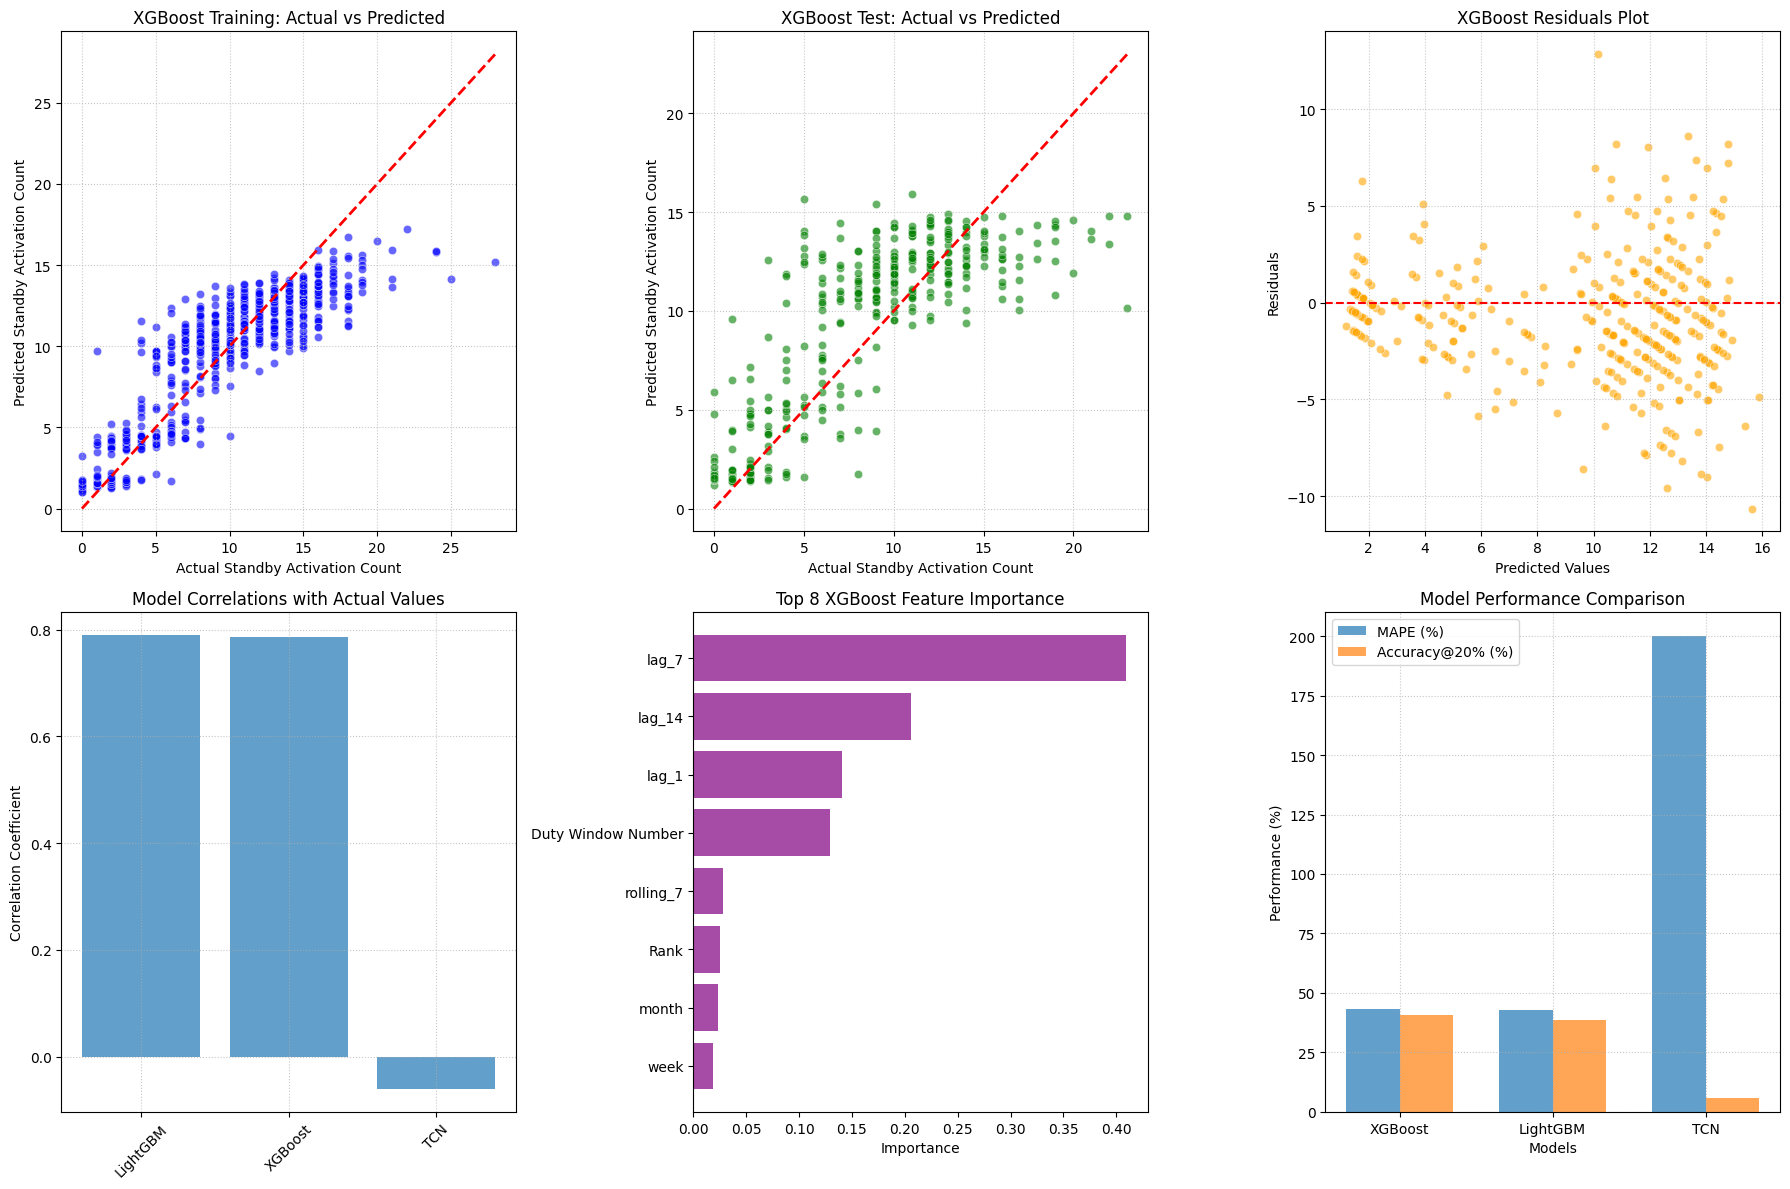


📊 XGBoost Performance Summary Table:


,Metric,Value
0,MAPE (%),43.1
1,WAPE (%),29.1
2,sMAPE (%),37.9
3,NRMSE (%),38.6
4,Accuracy@10% (%),20.6
5,Accuracy@20% (%),40.6
6,Accuracy@30% (%),58.6



✅ XGBoost visualization and analysis completed!


In [58]:
# STEP 23: XGBoost Visualization - Actual vs Predicted
print("📊 Creating XGBoost visualization plots...")

# Training predictions for visualization
y_train_pred_xgb = best_xgb_model.predict(X_train)

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 12))

# 1. Training: Actual vs Predicted
plt.subplot(2, 3, 1)
sns.scatterplot(x=y_train, y=y_train_pred_xgb, alpha=0.6, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.title('XGBoost Training: Actual vs Predicted')
plt.xlabel('Actual Standby Activation Count')
plt.ylabel('Predicted Standby Activation Count')
plt.grid(True, linestyle=':', alpha=0.7)

# 2. Test: Actual vs Predicted
plt.subplot(2, 3, 2)
sns.scatterplot(x=y_test, y=pred_xgb_tuned, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('XGBoost Test: Actual vs Predicted')
plt.xlabel('Actual Standby Activation Count')
plt.ylabel('Predicted Standby Activation Count')
plt.grid(True, linestyle=':', alpha=0.7)

# 3. Residuals plot
plt.subplot(2, 3, 3)
residuals = y_test - pred_xgb_tuned
sns.scatterplot(x=pred_xgb_tuned, y=residuals, alpha=0.6, color='orange')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('XGBoost Residuals Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True, linestyle=':', alpha=0.7)

# 4. Model comparison if other models are available
if 'pred_tuned' in globals() and 'pred_test_tcn' in globals():
    plt.subplot(2, 3, 4)
    
    # Compare predictions from all three models
    comparison_data = pd.DataFrame({
        'Actual': y_test,
        'LightGBM': pred_tuned,
        'XGBoost': pred_xgb_tuned,
        'TCN': pred_test_tcn[:len(y_test)] if len(pred_test_tcn) >= len(y_test) else 
              list(pred_test_tcn) + [np.nan] * (len(y_test) - len(pred_test_tcn))
    })
    
    # Calculate correlations with actual values
    correlations = comparison_data.corr()['Actual'].drop('Actual').sort_values(ascending=False)
    
    plt.bar(correlations.index, correlations.values, alpha=0.7)
    plt.title('Model Correlations with Actual Values')
    plt.ylabel('Correlation Coefficient')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle=':', alpha=0.7)
    
elif 'pred_tuned' in globals():
    plt.subplot(2, 3, 4)
    
    # Compare LightGBM vs XGBoost
    comparison_data = pd.DataFrame({
        'Actual': y_test,
        'LightGBM': pred_tuned,
        'XGBoost': pred_xgb_tuned
    })
    
    correlations = comparison_data.corr()['Actual'].drop('Actual').sort_values(ascending=False)
    
    plt.bar(correlations.index, correlations.values, alpha=0.7, color=['lightblue', 'lightgreen'])
    plt.title('Model Correlations with Actual Values')
    plt.ylabel('Correlation Coefficient')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle=':', alpha=0.7)

# 5. Feature importance plot
plt.subplot(2, 3, 5)
top_features = xgb_feature_importance.head(8)
plt.barh(top_features['feature'], top_features['importance'], alpha=0.7, color='purple')
plt.title('Top 8 XGBoost Feature Importance')
plt.xlabel('Importance')
plt.gca().invert_yaxis()

# 6. Model performance metrics comparison
plt.subplot(2, 3, 6)
models_metrics = []
model_names = []

# XGBoost metrics
models_metrics.append([mape_xgb_tuned, acc_20pct_xgb_tuned])
model_names.append('XGBoost')

# Add other models if available
if 'mape_tuned' in globals():
    models_metrics.append([mape_tuned, acc_20pct_tuned])
    model_names.append('LightGBM')

if 'mape_test_tcn' in globals():
    models_metrics.append([mape_test_tcn, acc_20pct_test_tcn])
    model_names.append('TCN')

if len(models_metrics) > 1:
    metrics_df = pd.DataFrame(models_metrics, columns=['MAPE', 'Accuracy@20%'], index=model_names)
    
    # Create grouped bar chart
    x = np.arange(len(model_names))
    width = 0.35
    
    # Normalize MAPE to 0-100 scale for better visualization
    normalized_mape = [mape/100 * 100 for mape in metrics_df['MAPE']]
    
    plt.bar(x - width/2, normalized_mape, width, label='MAPE (%)', alpha=0.7)
    plt.bar(x + width/2, metrics_df['Accuracy@20%'], width, label='Accuracy@20% (%)', alpha=0.7)
    
    plt.xlabel('Models')
    plt.ylabel('Performance (%)')
    plt.title('Model Performance Comparison')
    plt.xticks(x, model_names)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
else:
    plt.text(0.5, 0.5, 'XGBoost Model\nPerformance', ha='center', va='center', 
             transform=plt.gca().transAxes, fontsize=14)
    plt.title('XGBoost Performance Summary')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Summary statistics table
print("\n📊 XGBoost Performance Summary Table:")
summary_table = pd.DataFrame({
    'Metric': ['MAPE (%)', 'WAPE (%)', 'sMAPE (%)', 'NRMSE (%)', 
               'Accuracy@10% (%)', 'Accuracy@20% (%)', 'Accuracy@30% (%)'],
    'Value': [f"{mape_xgb_tuned:.1f}", f"{wape_xgb_tuned:.1f}", f"{smape_xgb_tuned:.1f}", 
              f"{nrmse_xgb_tuned:.1f}", f"{acc_10pct_xgb_tuned:.1f}", 
              f"{acc_20pct_xgb_tuned:.1f}", f"{acc_30pct_xgb_tuned:.1f}"]
})

display(summary_table)

print("\n✅ XGBoost visualization and analysis completed!")